In [31]:
import numpy as np
import os
import matplotlib.pyplot as plt

os.environ["KERAS_BACKEND"] = "torch"
import keras
keras.utils.set_random_seed(812)

In [32]:
#create synthetic time series random uniform integers
n = 1000
data = np.random.randint(1, 6, n)

#select random timewindows of length 5 without overlapping
motif_indexes = []
motif_pattern = [1,3,5,3,1]
p = len(motif_pattern)

max_interval = n // 20
last_index = 0
while True:
    index_interval = np.random.randint(p, p + max_interval)
    if last_index + index_interval + p > n:
        break
    last_index = last_index + index_interval
    motif_indexes.append(last_index)


motif_indexes


[47,
 99,
 135,
 160,
 174,
 190,
 199,
 228,
 281,
 328,
 337,
 380,
 433,
 460,
 481,
 493,
 544,
 587,
 611,
 622,
 653,
 684,
 698,
 719,
 743,
 779,
 819,
 851,
 885,
 909,
 946]

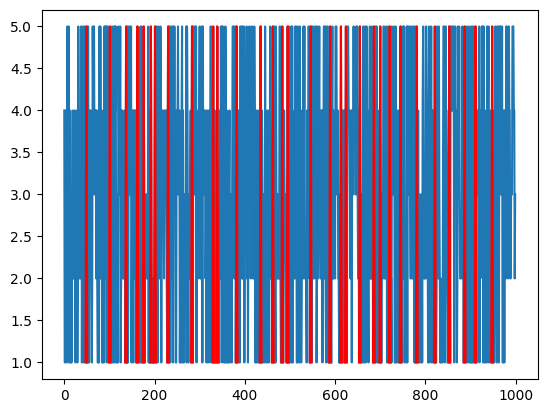

In [33]:
#change the values of the time series in the selected timewindows to the motif pattern
for idx in motif_indexes:
    data[idx:idx+p] = motif_pattern

#plot the data and in red the motif pattern
plt.plot(data)
for idx in motif_indexes:
    plt.plot(range(idx, idx+p), motif_pattern, 'r')

In [34]:
from keras.preprocessing.sequence import pad_sequences

def create_dataset(data, look_back, motif_indexes):
    X1, X2, y1, y = list(), list(), list(), list()
    for idx in range(len(data) - look_back - 1):
        next_motif_idx = [motif_idx for motif_idx in motif_indexes if motif_idx > idx + look_back]
        dist_to_next_motif = next_motif_idx[0] - idx if next_motif_idx else -1
        data_x1 = data[idx:idx+look_back]
        data_x2 = [motif_idx for motif_idx in motif_indexes if motif_idx <= idx+look_back]
        data_y1 = data[idx+look_back]
        data_y = dist_to_next_motif
        X1.append(data_x1)
        X2.append(data_x2)
        y1.append(data_y1)
        y.append(data_y)

    X2 = pad_sequences(X2, padding='post', value=-1, dtype=int)
    return np.array(X1), np.array(X2), np.array(y1), np.array(y)

In [35]:
look_back = 50
X1, X2, y1, y  = create_dataset(data, look_back=look_back, motif_indexes=motif_indexes)
print(X1[0], X2[0], y1[0], y[0])

[4 1 1 4 2 4 1 5 3 4 5 1 1 4 1 3 1 3 3 4 2 3 2 4 2 1 3 4 3 1 2 5 3 2 3 4 2
 5 5 1 3 4 5 1 4 5 2 1 3 5] [47 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1] 3 99


In [36]:
#train are the first 80% of the X
X1_train = X1[:int(0.8*len(X1))]
X2_train = X2[:int(0.8*len(X2))]
X1_test = X1[int(0.8*len(X1)):]
X2_test = X2[int(0.8*len(X2)):]
X1_val = X1_test[:int(0.5*len(X1_test))]
X2_val = X2_test[:int(0.5*len(X2_test))]
X1_test = X1_test[int(0.5*len(X1_test)):]
X2_test = X2_test[int(0.5*len(X2_test)):]
y1_train = y1[:int(0.8*len(y1))]
y_train = y[:int(0.8*len(y))]
y1_test = y1[int(0.8*len(y1)):]
y_test = y[int(0.8*len(y)):]
y1_val = y1_test[:int(0.5*len(y1_test))]
y_val = y_test[:int(0.5*len(y_test))]
y1_test = y1_test[int(0.5*len(y1_test)):]
y_test = y_test[int(0.5*len(y_test)):]


from sklearn.utils import shuffle
X1_train, X2_train, y1_train, y_train = shuffle(X1_train, X2_train, y1_train, y_train)
X1_val, X2_val, y1_val, y_val = shuffle(X1_val, X2_val, y1_val, y_val)
X1_test, X2_test, y1_test, y_test = shuffle(X1_test, X2_test, y1_test, y_test)

#reshape input to be [samples, time steps, features]
X1_train = np.reshape(X1_train, (X1_train.shape[0],  X1_train.shape[1], 1))
X2_train = np.reshape(X2_train, (X2_train.shape[0],  X2_train.shape[1], 1))
X1_test = np.reshape(X1_test, (X1_test.shape[0],  X1_test.shape[1], 1))
X2_test = np.reshape(X2_test, (X2_test.shape[0],  X2_test.shape[1], 1))

X1_train.shape, X1_test.shape, X1_val.shape, X2_train.shape, X2_test.shape, X2_val.shape, y1_train.shape, y1_test.shape, y1_val.shape, y_test.shape, y_val.shape

((759, 50, 1),
 (95, 50, 1),
 (95, 50),
 (759, 31, 1),
 (95, 31, 1),
 (95, 31),
 (759,),
 (95,),
 (95,),
 (95,),
 (95,))

In [37]:
#train lstm
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Masking
from keras import Input

def create_model(hp):
    model = Sequential()
    model.add(Input(shape=(X2_train.shape[1], X2_train.shape[2])))
    model.add(Masking(mask_value=-1))
    hp_units = hp.Int('units', min_value=2, max_value=12, step=1)
    model.add(LSTM(units=hp_units, activation='relu', return_sequences=False))
    model.add(Dense(1))
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01])
    model.compile(loss='mse', optimizer=Adam(learning_rate=hp_learning_rate), metrics=['mae'])
    return model

In [38]:
import keras_tuner as kt
from keras.callbacks import EarlyStopping


tuner= kt.RandomSearch(
        create_model,
        objective='mae',
        max_trials=50,
        executions_per_trial=3,
        project_name='lstm_tuning'
        )

tuner.search(
        x=X2_train,
        y=y_train,
        epochs=300,
        batch_size=32,
        validation_data=(X2_val,y_val),
        callbacks=[EarlyStopping('val_loss', patience=10)]
        )


Reloading Tuner from ./lstm_tuning/tuner0.json


In [39]:
tuner.results_summary()

Results summary
Results in ./lstm_tuning
Showing 10 best trials
Objective(name="mae", direction="min")

Trial 00 summary
Hyperparameters:
units: 4
learning_rate: 0.01
Score: 12.640617370605469

Trial 06 summary
Hyperparameters:
units: 5
learning_rate: 0.01
Score: 17.135688463846844

Trial 07 summary
Hyperparameters:
units: 2
learning_rate: 0.01
Score: 17.84181563059489

Trial 02 summary
Hyperparameters:
units: 9
learning_rate: 0.01
Score: 24.655410766601562

Trial 05 summary
Hyperparameters:
units: 8
learning_rate: 0.01
Score: 27.485493342081707

Trial 08 summary
Hyperparameters:
units: 6
learning_rate: 0.01
Score: 28.33133824666341

Trial 01 summary
Hyperparameters:
units: 10
learning_rate: 0.01
Score: 28.70683415730794

Trial 04 summary
Hyperparameters:
units: 11
learning_rate: 0.01
Score: 32.15748914082845

Trial 03 summary
Hyperparameters:
units: 12
learning_rate: 0.01
Score: 38.70940907796224


In [40]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/home/mgsilva/miniconda3/envs/motifpredenv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 31, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 4)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
MSE: 2044.9122255350212
MAE: 38.119379224275285
R2: -0.7039896770329384


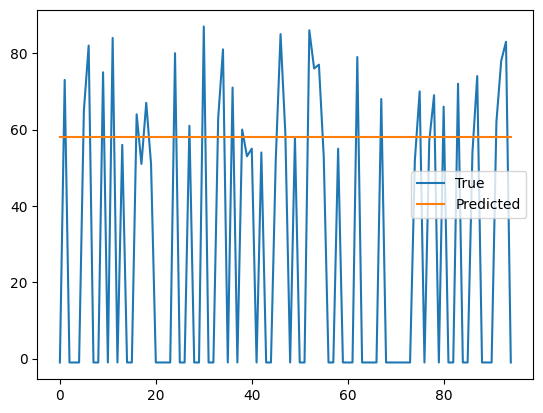

In [41]:
#evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = best_model.predict(X2_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()

In [42]:
def create_model_embeddinglstm(hp):
    model = Sequential()
    model.add(Input(shape=(X1_train.shape[1], X1_train.shape[2])))
    model.add(LSTM(units=50, activation='tanh', return_sequences=False))
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01,0.001])
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=Adam(learning_rate=hp_learning_rate), metrics=['mae'])
    return model

import keras_tuner as kt
from keras.callbacks import EarlyStopping

tuner= kt.RandomSearch(
        create_model_embeddinglstm,
        objective='mae',
        max_trials=10,
        executions_per_trial=3,
        project_name = 'embeddinglstm'
        )

tuner.search(
        x=X1_train,
        y=y1_train,
        epochs=500,
        batch_size=32,
        validation_data=(X1_val,y1_val),
        callbacks=[EarlyStopping('val_loss', patience=10)],
        )


Trial 2 Complete [00h 00m 22s]
mae: 1.2117656071980794

Best mae So Far: 1.2117656071980794
Total elapsed time: 00h 00m 47s


In [43]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/home/mgsilva/miniconda3/envs/motifpredenv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
MSE: 2.0545677300109504
MAE: 1.2094635294360134
R2: 0.007730070746385098


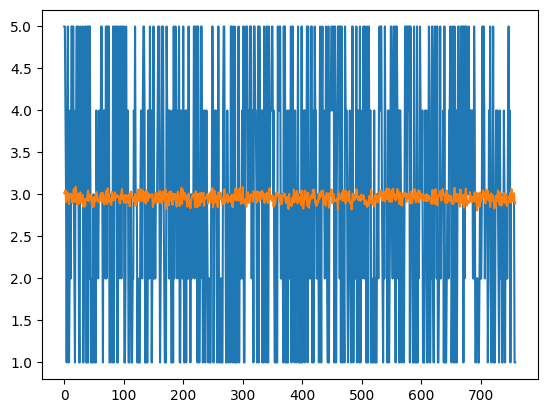

In [44]:
#evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y1_train_pred = best_model.predict(X1_train)
mse = mean_squared_error(y1_train, y1_train_pred)
mae = mean_absolute_error(y1_train, y1_train_pred)
r2 = r2_score(y1_train, y1_train_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

plt.plot(y1_train, label='True')
plt.plot(y1_train_pred, label='Predicted')



In [45]:
#get the embedding layer
embeddings = best_model.layers[1].get_weights()[0]
#embeddings to 1d array
embeddings = embeddings.flatten()
embeddings

array([ 0.06397434,  0.08280385,  0.07322982,  0.2679835 ,  0.20519653,
       -0.3221334 , -0.17364034,  0.21155837,  0.34864345, -0.356053  ,
       -0.03625767, -0.3279487 ,  0.16917618, -0.32079402, -0.06623118,
       -0.2927027 ,  0.07963596,  0.034455  , -0.2251645 , -0.31363493,
        0.2850361 , -0.12476523, -0.13342145,  0.00548272,  0.05163071,
        0.17114924, -0.12697871, -0.21764517, -0.0456266 ,  0.19312131,
        0.34596282,  0.23705178,  0.2956376 ,  0.02534868,  0.09302644,
        0.30155614, -0.20683458, -0.33548534, -0.22927958,  0.30172488,
        0.10072839,  0.31944332, -0.02469732, -0.15231806,  0.11218943,
        0.18516988,  0.27542204,  0.11881028, -0.22858566, -0.04230416],
      dtype=float32)

In [46]:
#join the embeddings with the motif indexes
X_train = []
for x2 in X2_train:
    #concat embeddigs with x2
    x2 = x2.flatten()
    x2 = np.concatenate((embeddings, x2))
    X_train.append(x2)

X_train = np.array(X_train)

X_test = []
for x2 in X2_test:
    #concat embeddigs with x2
    x2 = x2.flatten()
    x2 = np.concatenate((embeddings, x2))
    X_test.append(x2)

X_test = np.array(X_test)
X_train.shape


(759, 81)

In [47]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

MSE: 121.87022405144268
MAE: 8.968385502911996
R2: 0.2705336568879829


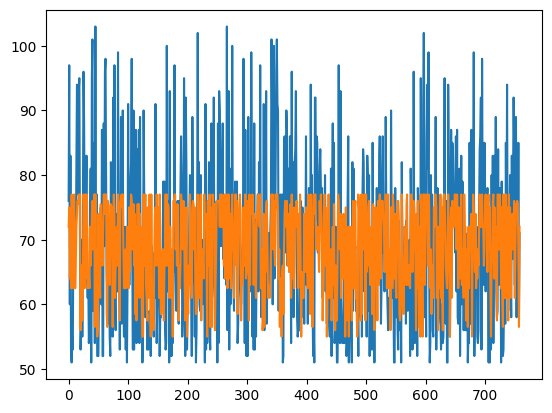

In [48]:
#evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

y_train_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

plt.plot(y_train, label='True')
plt.plot(y_train_pred, label='Predicted')

MSE: 3352.531994165909
MAE: 47.91042368035568
R2: -1.7936064143226105


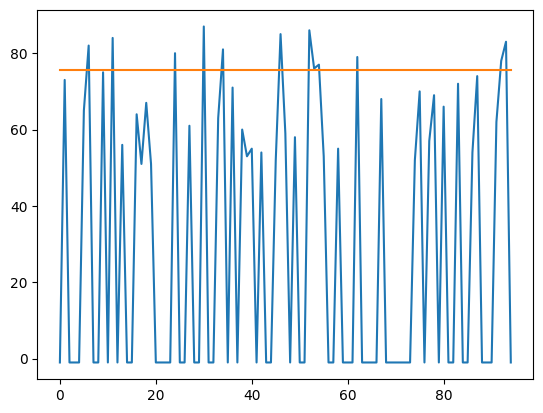

In [49]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')


In [50]:
#join the embeddings with the motif indexes and the motif pattern
X_train = []
for x2 in X2_train:
    #concat embeddigs with x2
    x2 = x2.flatten()
    x2 = np.concatenate((embeddings, x2, motif_pattern))
    X_train.append(x2)

X_train = np.array(X_train)

X_test = []
for x2 in X2_test:
    #concat embeddigs with x2
    x2 = x2.flatten()
    x2 = np.concatenate((embeddings, x2, motif_pattern))
    X_test.append(x2)

X_test = np.array(X_test)
X_train.shape


(759, 86)